In [2]:
import pandas as pd
from collections import defaultdict

# === Load Demand Data ===
demand_df = pd.read_csv("customer_demand.csv")

# === Step 1: Preprocess Dates ===
demand_df["Customer Promised Date"] = pd.to_datetime(demand_df["Customer Promised Date"])
demand_df["date_str"] = demand_df["Customer Promised Date"].dt.strftime("%Y-%m-%d")

# === Step 2: Infer Journey Type ===
# Assumption:
# - If destination starts with TR_CU → it's an import (to customer)
# - If destination starts with TR_OP → it's an export (to port)
def infer_journey_type(row):
    dest = row["destination_location_id"]
    if isinstance(dest, str) and dest.startswith("TR_CU"):
        return "import"
    elif isinstance(dest, str) and dest.startswith("TR_OP"):
        return "export"
    else:
        return "unknown"

demand_df["journey_type"] = demand_df.apply(infer_journey_type, axis=1)

# === Step 3: Aggregate Shipment Volumes by Location/Date/Journey Type ===
journey_summary = (
    demand_df.groupby(["destination_location_id", "date_str", "journey_type"])["q_i"]
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

# === Step 4: Mark Locations with Both Import and Export on the Same Day ===
journey_summary["paired"] = (journey_summary.get("import", 0) > 0) & (journey_summary.get("export", 0) > 0)

# === Step 5: Report Summary Statistics ===
total_cases = len(journey_summary)
paired_cases = journey_summary["paired"].sum()
percent_paired = 100 * paired_cases / total_cases if total_cases > 0 else 0

# === Step 6: Print or Save Results ===
print(f"\nTotal location-date combinations: {total_cases}")
print(f"Paired import/export opportunities: {paired_cases}")
print(f"Pairing ratio: {percent_paired:.2f}%")

# === Optional: Export detailed pairing report ===
journey_summary.to_csv("import_export_pairing_summary.csv", index=False)


Total location-date combinations: 1346
Paired import/export opportunities: 0
Pairing ratio: 0.00%


In [3]:
# Filter imports and exports
imports = demand_df[demand_df["journey_type"] == "import"]
exports = demand_df[demand_df["journey_type"] == "export"]

# Step 1: Select subset of imports
import_subset = imports.sample(n=100, random_state=42)

# Step 2: Convert to synthetic exports by changing the destination ID
synthetic_exports = import_subset.copy()
synthetic_exports["journey_type"] = "export"
synthetic_exports["destination_location_id"] = synthetic_exports["destination_location_id"]  # keep same
synthetic_exports["q_i"] = synthetic_exports["q_i"]  # or modify to simulate changes

# Step 3: Combine with original imports
synthetic_balanced = pd.concat([imports, synthetic_exports]).reset_index(drop=True)

In [4]:
# Group by destination-location and date
journey_summary = (
    synthetic_balanced.groupby(["destination_location_id", "date_str", "journey_type"])["q_i"]
    .sum().unstack(fill_value=0).reset_index()
)
journey_summary["paired"] = (journey_summary.get("import", 0) > 0) & (journey_summary.get("export", 0) > 0)


In [5]:
!pip install gurobipy

import pandas as pd
from collections import defaultdict
import gurobipy as gp
from gurobipy import GRB

# === Load Data ===
arcs_df = pd.read_csv("cleaned_arcs.csv")
demand_df = pd.read_csv("customer_demand.csv")

# === Preprocess Dates ===
demand_df["Customer Promised Date"] = pd.to_datetime(demand_df["Customer Promised Date"])
demand_df["date_str"] = demand_df["Customer Promised Date"].dt.strftime("%Y-%m-%d")
dates = sorted(demand_df["date_str"].unique())
container_types = demand_df["container_type"].unique()

# === Build Demand Dictionary ===
demand = {}
for _, row in demand_df.iterrows():
    key = (row["destination_location_id"], row["container_type"], row["date_str"])
    demand[key] = demand.get(key, 0) + row["q_i"]

# === Sets & Parameters ===
fixed_cost_per_km = 1.0
spot_multiplier = 1.15
max_fixed_trucks = 200

nodes = set(arcs_df['source_location_id']).union(set(arcs_df['destination_location_id']))
arcs = list(zip(arcs_df['source_location_id'], arcs_df['destination_location_id']))
distance = {(row['source_location_id'], row['destination_location_id']): row['avg_distance']
            for _, row in arcs_df.iterrows()}

# === Valid Keys for Variables ===
valid_keys = set()
for (j, k, d) in demand:
    for (i, j2) in arcs:
        if j == j2:
            valid_keys.add((i, j, k, d))

print(f"Model has {len(valid_keys)} shipment variables per fleet (xf and xs)")

# === Setup Gurobi Environment ===
params = {
    "WLSACCESSID": 'ec828830-76d0-44e5-9bb2-c4b5d17aaa83',
    "WLSSECRET": '3e1ca4d0-89ff-47ce-87d2-9219c0609fae',
    "LICENSEID": 2615231
}
env = gp.Env(params=params)

# === Run Full Optimization at 350 Fixed Trucks ===
full_limit = 350
model = gp.Model(env=env)
model.setParam("TimeLimit", 300)

# Decision Variables
xf = model.addVars(valid_keys, vtype=GRB.INTEGER, lb=0, name="xf")
xs = model.addVars(valid_keys, vtype=GRB.INTEGER, lb=0, name="xs")
total_spot = model.addVar(vtype=GRB.CONTINUOUS, name="total_spot")

# Demand Constraints
for (j, k, d) in demand:
    incoming = [(i, j2, k1, d1) for (i, j2, k1, d1) in valid_keys if j == j2 and k == k1 and d == d1]
    total = gp.quicksum(xf[i, j, k, d] + xs[i, j, k, d] for (i, j, k, d) in incoming)
    model.addConstr(total >= demand[(j, k, d)], name=f"demand_{j}_{k}_{d}")

# Daily Fixed Truck Limits
for d in dates:
    daily_fixed_total = gp.quicksum(xf[i, j, k, d1] for (i, j, k, d1) in valid_keys if d1 == d)
    model.addConstr(daily_fixed_total <= full_limit, name=f"fixed_limit_{d}")

# Spot Tracker Constraint
model.addConstr(
    total_spot == gp.quicksum(xs[i, j, k, d] for (i, j, k, d) in valid_keys),
    name="spot_total"
)

# Objective Function
model.setObjective(
    gp.quicksum(
        (fixed_cost_per_km) * distance[i, j] * xf[i, j, k, d] +
        (fixed_cost_per_km * spot_multiplier) * distance[i, j] * xs[i, j, k, d]
        for (i, j, k, d) in valid_keys
    ) + 50 * total_spot,
    GRB.MINIMIZE
)

model.optimize()

if model.status in [GRB.OPTIMAL, GRB.TIME_LIMIT]:
    print(f"\n✅ Full Optimization Complete:")
    print(f"Objective: {model.ObjVal:.2f}")
    print(f"Spot Trucks Used: {total_spot.X:.0f}")
    print(f"Fixed Trucks Used: {sum(xf[i, j, k, d].X for (i, j, k, d) in valid_keys)}")
else:
    print(f"❌ Optimization failed or infeasible (status: {model.status})")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 64.4 MB/s eta 0:00:00
Model has 525881 shipment variables per fleet (xf and xs)
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2615231
Academic license 2615231 - for non-commercial use only - registered to ng___@andrew.cmu.edu
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
TimeLimit  300

Academic license 2615231 - for non-commercial use only - registered to ng___@andrew.cmu.edu
Optimize a model with 2282 rows, 1051763 columns and 2103525 nonzeros
Model fingerprint: 0x878a85d1
Variable types: 1 continuous, 1051762 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+01, 5e+03]
  Bounds range     [0e+00, 

In [6]:
# === Sensitivity Loop: When Do Spot Trucks First Appear? ===
results = []
print("\n=== Exploring Spot Truck Trigger Threshold ===")

for limit in range(340, 0, -50):
    print(f"\n🔄 Trying with max_fixed_trucks = {limit}")
    model = gp.Model(env=env)
    model.setParam("TimeLimit", 300)

    xf = model.addVars(valid_keys, vtype=GRB.INTEGER, lb=0, name="xf")
    xs = model.addVars(valid_keys, vtype=GRB.INTEGER, lb=0, name="xs")
    total_spot = model.addVar(vtype=GRB.CONTINUOUS, name="total_spot")

    for (j, k, d) in demand:
        incoming = [(i, j2, k1, d1) for (i, j2, k1, d1) in valid_keys if j == j2 and k == k1 and d == d1]
        total = gp.quicksum(xf[i, j, k, d] + xs[i, j, k, d] for (i, j, k, d) in incoming)
        model.addConstr(total >= demand[(j, k, d)], name=f"demand_{j}_{k}_{d}")

    for d in dates:
        daily_fixed_total = gp.quicksum(xf[i, j, k, d1] for (i, j, k, d1) in valid_keys if d1 == d)
        model.addConstr(daily_fixed_total <= limit, name=f"fixed_limit_{d}")

    model.addConstr(
        total_spot == gp.quicksum(xs[i, j, k, d] for (i, j, k, d) in valid_keys),
        name="spot_total"
    )

    model.setObjective(
        gp.quicksum(
            (fixed_cost_per_km) * distance[i, j] * xf[i, j, k, d] +
            (fixed_cost_per_km * spot_multiplier) * distance[i, j] * xs[i, j, k, d]
            for (i, j, k, d) in valid_keys
        ) + 50 * total_spot,
        GRB.MINIMIZE
    )

    model.optimize()

    if model.status in [GRB.OPTIMAL, GRB.TIME_LIMIT]:
        spot_used = total_spot.X
        print(f"Objective: {model.ObjVal:.2f} | Spot Trucks Used: {spot_used:.0f}")
        results.append({
            "fixed_limit": limit,
            "objective": model.ObjVal,
            "spot_trucks": spot_used,
        })
        if spot_used > 0:
            print(f"⚠️ Spot trucks first triggered at fixed limit: {limit}")
            break
    else:
        print(f"Model infeasible or error (status: {model.status})")


=== Exploring Spot Truck Trigger Threshold ===

🔄 Trying with max_fixed_trucks = 340
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
TimeLimit  300

Academic license 2615231 - for non-commercial use only - registered to ng___@andrew.cmu.edu
Optimize a model with 2282 rows, 1051763 columns and 2103525 nonzeros
Model fingerprint: 0x533282c7
Variable types: 1 continuous, 1051762 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+01, 5e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 3731325.6109
Presolve removed 29 rows and 1047867 columns
Presolve time: 2.54s
Presolved: 2253 rows, 3896 columns, 5816 nonzeros
Found heuristic solution: ob

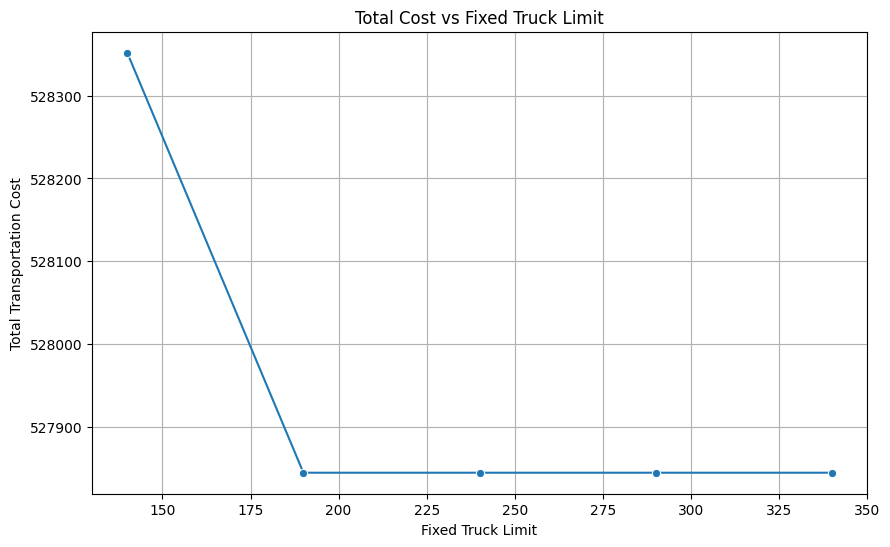

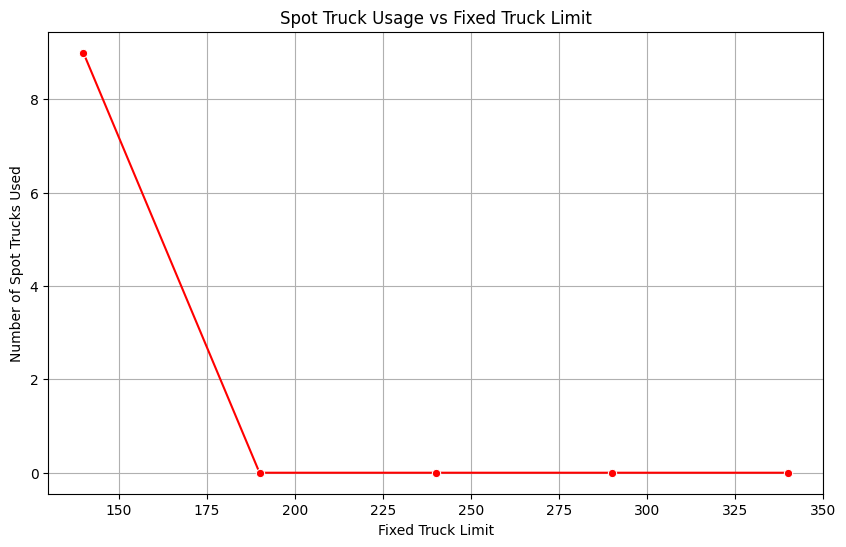

KeyError: 'fixed_trucks'

<Figure size 1000x600 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Convert results to DataFrame
df = pd.DataFrame(results).sort_values(by="fixed_limit")

# Plot 1: Total Cost vs Fixed Truck Limit
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="fixed_limit", y="objective", marker="o")
plt.title("Total Cost vs Fixed Truck Limit")
plt.xlabel("Fixed Truck Limit")
plt.ylabel("Total Transportation Cost")
plt.grid(True)
plt.show()

# Plot 2: Spot Truck Usage vs Fixed Truck Limit
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="fixed_limit", y="spot_trucks", marker="o", color="red")
plt.title("Spot Truck Usage vs Fixed Truck Limit")
plt.xlabel("Fixed Truck Limit")
plt.ylabel("Number of Spot Trucks Used")
plt.grid(True)
plt.show()

# Plot 3: Fixed vs Spot Trucks (Stacked Bar)
plt.figure(figsize=(10, 6))
plt.bar(df["fixed_limit"], df["fixed_trucks"], label="Fixed Trucks")
plt.bar(df["fixed_limit"], df["spot_trucks"], bottom=df["fixed_trucks"], label="Spot Trucks", color="salmon")
plt.title("Fixed vs Spot Trucks by Fleet Limit")
plt.xlabel("Fixed Truck Limit")
plt.ylabel("Number of Trucks Used")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
!pip install gurobipy

import pandas as pd
import numpy as np
from collections import defaultdict
import gurobipy as gp
from gurobipy import GRB

# === Load Data ===
arcs_df = pd.read_csv("cleaned_arcs.csv")
demand_df = pd.read_csv("customer_demand.csv")

# === Preprocess Dates ===
demand_df["Customer Promised Date"] = pd.to_datetime(demand_df["Customer Promised Date"])
demand_df["date_str"] = demand_df["Customer Promised Date"].dt.strftime("%Y-%m-%d")
dates = sorted(demand_df["date_str"].unique())
container_types = demand_df["container_type"].unique()

# === Sets & Parameters ===
fixed_cost_per_km = 1.0
spot_multiplier = 1.15
original_fixed_truck_limit = 350
sample_frac = 0.5
fleet_scale = 0.5
n_runs = 10

nodes = set(arcs_df['source_location_id']).union(set(arcs_df['destination_location_id']))
arcs = list(zip(arcs_df['source_location_id'], arcs_df['destination_location_id']))
distance = {(row['source_location_id'], row['destination_location_id']): row['avg_distance']
            for _, row in arcs_df.iterrows()}

params = {
    "WLSACCESSID": 'ec828830-76d0-44e5-9bb2-c4b5d17aaa83',
    "WLSSECRET": '3e1ca4d0-89ff-47ce-87d2-9219c0609fae',
    "LICENSEID": 2615231
}
env = gp.Env(params=params)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2615231
Academic license 2615231 - for non-commercial use only - registered to ng___@andrew.cmu.edu



=== Bootstrap Run 1/10 ===
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
TimeLimit  300

Academic license 2615231 - for non-commercial use only - registered to ng___@andrew.cmu.edu
Optimize a model with 1105 rows, 425475 columns and 850949 nonzeros
Model fingerprint: 0x091b0e5b
Variable types: 1 continuous, 425474 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+01, 5e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 1775096.3155
Presolve removed 125 rows and 423933 columns
Presolve time: 0.75s
Presolved: 980 rows, 1542 columns, 2235 nonzeros
Found heuristic solution: objective 273053.37471
Variable types: 0 continuous, 1542 intege

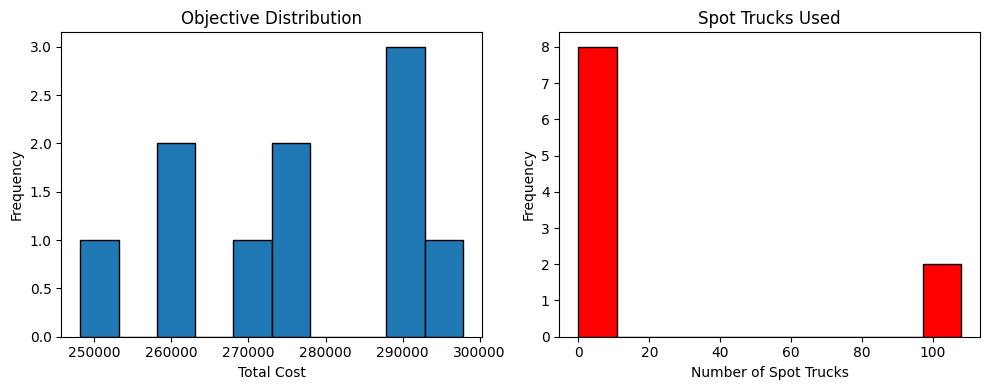

In [9]:
import matplotlib.pyplot as plt

bootstrap_results = []

for run in range(n_runs):
    print(f"\n=== Bootstrap Run {run+1}/{n_runs} ===")

    sampled_demand = demand_df.sample(frac=sample_frac, replace=True, random_state=run)

    demand = {}
    for _, row in sampled_demand.iterrows():
        key = (row["destination_location_id"], row["container_type"], row["date_str"])
        demand[key] = demand.get(key, 0) + row["q_i"]

    max_fixed_trucks = int(original_fixed_truck_limit * fleet_scale)

    valid_keys = set()
    for (j, k, d) in demand:
        for (i, j2) in arcs:
            if j == j2:
                valid_keys.add((i, j, k, d))

    model = gp.Model(env=env)
    model.setParam("TimeLimit", 300)

    xf = model.addVars(valid_keys, vtype=GRB.INTEGER, lb=0, name="xf")
    xs = model.addVars(valid_keys, vtype=GRB.INTEGER, lb=0, name="xs")
    total_spot = model.addVar(vtype=GRB.CONTINUOUS, name="total_spot")

    for (j, k, d) in demand:
        incoming = [(i, j2, k1, d1) for (i, j2, k1, d1) in valid_keys if j == j2 and k == k1 and d == d1]
        total = gp.quicksum(xf[i, j, k, d] + xs[i, j, k, d] for (i, j, k, d) in incoming)
        model.addConstr(total >= demand[(j, k, d)])

    for d in dates:
        model.addConstr(
            gp.quicksum(xf[i, j, k, d1] for (i, j, k, d1) in valid_keys if d1 == d) <= max_fixed_trucks
        )

    model.addConstr(
        total_spot == gp.quicksum(xs[i, j, k, d] for (i, j, k, d) in valid_keys)
    )

    model.setObjective(
        gp.quicksum(
            fixed_cost_per_km * distance[i, j] * xf[i, j, k, d] +
            fixed_cost_per_km * spot_multiplier * distance[i, j] * xs[i, j, k, d]
            for (i, j, k, d) in valid_keys
        ) + 50 * total_spot,
        GRB.MINIMIZE
    )

    model.optimize()

    if model.status in [GRB.OPTIMAL, GRB.TIME_LIMIT]:
        bootstrap_results.append({
            "run": run,
            "objective": model.ObjVal,
            "spot_trucks": total_spot.X,
            "fixed_truck_limit": max_fixed_trucks,
            "demand_size": len(sampled_demand)
        })
        print(f"Objective: {model.ObjVal:.2f} | Spot Trucks: {total_spot.X}")
    else:
        print("Model failed.")

# === Plot Results ===
df = pd.DataFrame(bootstrap_results)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df['objective'], bins=10, edgecolor='black')
plt.title("Objective Distribution")
plt.xlabel("Total Cost")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(df['spot_trucks'], bins=10, edgecolor='black', color='red')
plt.title("Spot Trucks Used")
plt.xlabel("Number of Spot Trucks")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()